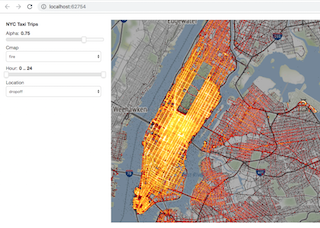

## NYC Taxi data with Datashader and Panel

The [NYC Taxi trips](https://anaconda.org/jbednar/nyc_taxi/notebook) dataset is a well-studied data science example. Here we show how to build a simple dashboard for exploring 10 million taxi trips in a Jupyter notebook using [Datashader](http://datashader.org), then deploying it as a standalone dashboard using [Panel](http://panel.pyviz.org).

Running the dashboard requires having a live Python process running (not just a static webpage or anaconda.org notebook viewer).  Before you run the notebook or server, you'll need to set up a [conda](http://conda.pydata.org/miniconda.html) environment and run `conda install -c pyviz datashader panel geoviews`, and you'll need to [get the data file](https://anaconda.org/jbednar/nyc_taxi/notebook).

In [ ]:
import holoviews as hv, param, dask.dataframe as dd
import panel as pn

from colorcet import cm
from holoviews.operation.datashader import rasterize, shade
from holoviews.streams import RangeXY
from holoviews.element.tiles import StamenTerrain

hv.extension('bokeh', logo=False)

usecols = ['dropoff_x','dropoff_y','pickup_x','pickup_y','dropoff_hour','pickup_hour','passenger_count']
df = dd.read_parquet('data/nyc_taxi_wide.parq')[usecols].persist()
opts = dict(width=1000,height=600,xaxis=None,yaxis=None,bgcolor='black',show_grid=False)
cmaps = ['fire','bgy','bgyw','bmy','gray','kbc']


class NYCTaxiExplorer(param.Parameterized):
    alpha      = param.Magnitude(default=0.75, doc="Alpha value for the map opacity")
    cmap       = param.ObjectSelector(cm['fire'], objects={c:cm[c] for c in cmaps})
    hour       = param.Range(default=(0, 24), bounds=(0, 24))
    location   = param.ObjectSelector(default='dropoff', objects=['dropoff', 'pickup'])

    @param.depends('location', 'hour')
    def points(self):
        points = hv.Points(df, kdims=[self.location+'_x', self.location+'_y'], vdims=['dropoff_hour'])
        if self.hour != (0, 24): points = points.select(dropoff_hour=self.hour)
        return points

    def view(self,**kwargs):
        points = hv.DynamicMap(self.points)
        tiles = StamenTerrain().apply.opts(alpha=self.param.alpha, **opts)
        agg = rasterize(points, x_sampling=1, y_sampling=1, width=600, height=400)
        return tiles * shade(agg, cmap=self.param.cmap)

taxi = NYCTaxiExplorer(name="NYC Taxi Trips")
pn.Row(taxi.param, taxi.view()).servable()

As you can see, the resulting object is rendered in the notebook (above), and it's usable as long as you have Python running on this code. You can also launch this app as a standalone server outside of the notebook, because we've marked the relevant object `.servable()`.  That declaration means that if someone later runs this notebook as a server process (using `panel serve --show nyc_taxi_panel.ipynb`), your browser will open a separate window with the serveable object ready to explore or share, just like the screenshot at the top of this notebook.

In [ ]:
#! panel serve --show --port 5009 nyc_taxi_panel.ipynb